# ML-Model - Advanced ML methods for Cultural Rappresentation Task (Network I)

 In this notebook we propose a novel Voting Schema with multiple binary classification estimators. The network implements a voting scheme based on three different trees:

* Cultural **Agnostic-Rappresentative** Estimator
* Cultural **Agnostic-Exclusive** Estimator
* Cultural **Exclusive-Rappresentative** Estimator

the most voted class will be the predicted class.

## Import Necessary Libraries

In [1201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFdr, chi2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import OneHotEncoder


## Dataset

### Load the dataset

In [1202]:
from typing import Optional

from sklearn.decomposition import PCA


def onehot_encode(
    dfs: list[pd.DataFrame],
    cat_cols: Optional[list[str]] = None,
    sparse: bool = False,
    handle_unknown: str = "ignore",
    pca_module: Optional[PCA] = None
) -> tuple[list[pd.DataFrame], OneHotEncoder, Optional[PCA]]:
    """
    Fit a OneHotEncoder on specified categorical columns of multiple DataFrames and
    return only the one-hot encoded features using scikit-learn. Optionally apply PCA.

    Args:
        dfs (list[pd.DataFrame]): List of DataFrames to encode.
        cat_cols (list[str], optional): Categorical columns. If None, infer object dtypes from first df.
        sparse (bool, optional): If True, returns sparse output; otherwise dense array. Defaults to False.
        handle_unknown (str, optional): Strategy for unknown categories. Defaults to 'ignore'.
        pca_module (PCA, optional): PCA instance to apply to the encoded features. Defaults to None.

    Returns:
        tuple[list[pd.DataFrame], OneHotEncoder, Optional[PCA]]:
            - List of DataFrames with encoded (and possibly PCA-transformed) columns.
            - Fitted OneHotEncoder instance.
            - Fitted PCA instance if provided, else None.
    """
    # Infer categorical columns
    df0 = dfs[0]
    if cat_cols is None:
        cat_cols = df0.select_dtypes(include="object").columns.tolist()

    # Fit encoder on all categories combined
    combined_cats = pd.concat([df[cat_cols] for df in dfs], ignore_index=True)
    encoder = OneHotEncoder(sparse_output=sparse, handle_unknown=handle_unknown)
    encoder.fit(combined_cats)

    # Generate feature names
    ohe_cols = encoder.get_feature_names_out(cat_cols)

    # Transform each DataFrame
    encoded_list: list[pd.DataFrame] = []
    for df in dfs:
        ohe_array = encoder.transform(df[cat_cols])
        arr = ohe_array.toarray() if sparse else ohe_array
        encoded_df = pd.DataFrame(arr, columns=ohe_cols, index=df.index)
        encoded_list.append(encoded_df)

    # Optionally apply PCA
    if pca_module is not None:
        all_data = pd.concat(encoded_list, axis=0)
        pca_module.fit(all_data)
        encoded_list = [pd.DataFrame(pca_module.transform(df), index=df.index) for df in encoded_list]

    return encoded_list, encoder, pca_module

### Load the Dataset

* train - *Silver Annotate* 6200 items
* test  - *Gold Annotate*   300 items (no labels)
* validation - *Gold Annotate* 300 items

In [1203]:
train = pd.read_csv('train.tsv', sep='\t')
validation = pd.read_csv('validation.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

In [1204]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6251 entries, 0 to 6250
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   length_lan     6251 non-null   float64
 1   type           6251 non-null   object 
 2   subcategory    6251 non-null   object 
 3   category       6251 non-null   object 
 4   G_mean_pr      6251 non-null   float64
 5   G_density      6251 non-null   float64
 6   G_num_cliques  6251 non-null   float64
 7   G_avg          6251 non-null   float64
 8   G_nodes        6251 non-null   float64
 9   n_visits       6251 non-null   float64
 10  back_links     6251 non-null   float64
 11  n_mod          6251 non-null   float64
 12  reference      6251 non-null   float64
 13  num_langs      6251 non-null   float64
 14  languages      6251 non-null   float64
 15  qid            6251 non-null   object 
 16  name           6251 non-null   object 
 17  wiki_name      6248 non-null   object 
 18  item    

## Features Selection

The features exstracted are grouped in many different categories. We have individuated three:

- **Static Features**: regard page structure, numbers of links and other aspects connected to the page that in general changes very slow
- **Semi-Dynamic Features**: regard information about wikipedia network like page references or page links, in general they tend to change in large amount of time
- **Dynamic Features**: Regard information about users and number of iteractions with corpus pages, in general they tend to change very quickly change very quicly and be very interesting because they allow us to classify instances based on natural cultural change

In the next cell we had selected the best features for our purposes

In [1205]:
# Labels
y_train = train[['label']]
y_validation = validation[['label']]
# Identificators
id_train = train[['wiki_name']]
id_validation = validation[['wiki_name']]
# Numeric features
fe_train = train[['G_nodes', 'G_num_cliques', 'G_density', 'G_mean_pr','languages','G_avg', 'num_langs', 'reference', 'n_mod', 'back_links', 'n_visits', 'length_lan']]
fe_validation = validation[['G_nodes', 'G_num_cliques', 'G_density', 'G_mean_pr', 'G_avg','languages', 'num_langs', 'reference', 'n_mod', 'back_links', 'n_visits', 'length_lan']]
fe_test = test[[ 'G_nodes', 'G_num_cliques', 'G_density', 'G_mean_pr','G_avg', 'languages', 'num_langs', 'reference', 'n_mod', 'back_links', 'n_visits', 'length_lan']]
# String features
fe_str_train = train[['category', 'subcategory', 'type']]
fe_str_validation = validation[['category', 'subcategory', 'type']]
fe_str_test = test[['category', 'subcategory', 'type']]

In [1206]:
from sklearn.feature_selection import SelectKBest
best_feactures_tr = set (SelectFdr(chi2, alpha=0.06).fit(fe_train, y_train).get_feature_names_out())
best_features_te  = set (SelectFdr(chi2, alpha=0.06).fit(fe_validation, y_validation).get_feature_names_out())

best_fe = best_feactures_tr.intersection(best_features_te)
print(f'best features for train set {best_feactures_tr}')
print(f'best features for validation set  {best_features_te}')

print(f'Absolute best features {best_fe}')

# Select 'absolute' best features
fe_train = train[list(best_fe)]
fe_validation = validation[list(best_fe)]
fe_test = test[list(best_fe)]

best features for train set {'num_langs', 'G_num_cliques', 'G_density', 'reference', 'back_links', 'length_lan', 'n_mod', 'G_mean_pr', 'n_visits', 'G_avg', 'G_nodes', 'languages'}
best features for validation set  {'num_langs', 'G_num_cliques', 'reference', 'back_links', 'length_lan', 'n_mod', 'G_mean_pr', 'n_visits', 'G_nodes', 'languages'}
Absolute best features {'num_langs', 'reference', 'G_num_cliques', 'back_links', 'length_lan', 'n_mod', 'G_mean_pr', 'n_visits', 'G_nodes', 'languages'}


In [1207]:
#######################################
# One-hot-encoding on string features #
#######################################
from sklearn.decomposition import PCA
cat, _, _ = onehot_encode([fe_str_train, fe_str_validation, fe_str_test], ['category'])
train_cat, validation_cat, test_cat =  cat

scat, _, _ = onehot_encode([fe_str_train, fe_str_validation, fe_str_test], ['subcategory'])
train_scat, validation_scat, test_scat = scat

t, _, _ = onehot_encode([fe_str_train, fe_str_validation, fe_str_test], ['type'] )
train_t, validation_t, test_t = t



In [1208]:
train_set = pd.concat([fe_train, train_cat, train_scat, train_t, y_train], axis=1)
validation_set = pd.concat([fe_validation, validation_cat, validation_scat, validation_t, y_validation], axis=1) 
test_set = pd.concat([fe_test, test_cat, test_scat, test_t], axis=1) 

In [1209]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Columns: 156 entries, num_langs to type_named entity
dtypes: float64(156)
memory usage: 365.8 KB


In [1210]:
print(train_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6251 entries, 0 to 6250
Columns: 157 entries, num_langs to label
dtypes: float64(156), int64(1)
memory usage: 7.5 MB
None


In [1211]:
validation_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Columns: 157 entries, num_langs to label
dtypes: float64(156), int64(1)
memory usage: 368.1 KB


## Network - Preliminar Experiments

In this section we tolking about proposed ML approach

### Agnostic-Representative Classifier

In [1212]:
# prepare the dataset in order to take only two classes and eliminates the labels of the elements
d = train_set.query("label == 0 or label == 1")
y = d['label'].astype(int).to_numpy()
x = d.drop(['label'], axis=1).astype(float).to_numpy()

In [1213]:
ar_tree = ExtraTreesClassifier().fit(x, y)

In [1214]:
d = validation_set.query("label == 0 or label == 1")
y = d['label'].astype(int).to_numpy()
x = d.drop(['label'], axis=1).astype(float).to_numpy()

In [1215]:
y_pred = ar_tree.predict(x)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       117
           1       0.86      0.83      0.85        76

    accuracy                           0.88       193
   macro avg       0.88      0.87      0.87       193
weighted avg       0.88      0.88      0.88       193



### Agnostic-Exclusive Classifier

In [1216]:
# prepare the dataset in order to take only two classes and eliminates the labels of the elements
d = train_set.query("label == 0 or label == 2")
y = d['label'].astype(int).to_numpy()
x = d.drop(['label'], axis=1).astype(float).to_numpy()

In [1217]:
ae_tree = ExtraTreesClassifier().fit(x, y)

In [1218]:
d = validation_set.query("label == 0 or label == 2")
y = d['label'].astype(int).to_numpy()
x = d.drop(['label'], axis=1).astype(float).to_numpy()

In [1219]:
y_pred = ae_tree.predict(x)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       117
           2       0.83      0.73      0.78       107

    accuracy                           0.80       224
   macro avg       0.80      0.80      0.80       224
weighted avg       0.80      0.80      0.80       224



### Representative-Exclusive Classifier

In [1220]:
# prepare the dataset in order to take only two classes and eliminates the labels of the elements
d = train_set.query("label == 1 or label == 2")
y = d['label'].astype(int).to_numpy()
x = d.drop(['label'], axis=1).astype(float).to_numpy()

In [1221]:
re_tree = ExtraTreesClassifier().fit(x, y)

In [1222]:
d = validation_set.query("label == 1 or label == 2")
y = d['label'].astype(int).to_numpy()
x = d.drop(['label'], axis=1).astype(float).to_numpy()

In [1223]:
y_pred = re_tree.predict(x)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.68      0.76      0.72        76
           2       0.82      0.75      0.78       107

    accuracy                           0.75       183
   macro avg       0.75      0.76      0.75       183
weighted avg       0.76      0.75      0.76       183



## Network - CABNet *(Cultural Advanced Binary Network)*

Follow propose projected Network based on Basic ml approchs for classificarion tasck


In [1224]:
class CABNet(BaseEstimator, ClassifierMixin):
    """
    Cultural-Classification Network:
      - ar: classifier for classes {Cultural Agnostic, Cultural Rappresentative} 
      - ae: classifier for classes {Cultural Agnostic, Cultural Exsclusive}
      - re: classifier for classes {Cultural Rappresentative, Cultural Exsclusive}
      - detector: optional unsupervised estimator to filter outliers
    
    The CABNet combine multiple binary estimators trained in discriminative and voting schema to produce accurate cultural
    prediction. To improve Accuracy of network is possibile use outliers detector, if neet, to detect and then remove outliers values
    during the train.

    Note:
        The network can be integrate in Sklearn Pipline grate to sklearn-like interface

    """
    def __init__(self,
                 ar_estimator,
                 ae_estimator,
                 re_estimator,
                 th=0.45,
                 th_ar=0,
                 th_ae=-0.6,
                 th_re=0,
                 detector=None) -> None:
        # Store base estimators for hyperparameter tuning
        self.ar_estimator = ar_estimator
        self.ae_estimator = ae_estimator
        self.re_estimator = re_estimator
        self.global_estimator = ExtraTreesClassifier()
        self.th = th
        self.th_ar = th_ar
        self.th_ae = th_ae
        self.th_re = th_re
        self.detector = detector
        
        # Label maps
        self._label_map = {
            'ar': {0, 1},
            'ae': {0, 2},
            're': {1, 2}
        }

    def _fit_binary(self, estimator, X, y):
        return estimator.fit(X, y)
        

    def fit(self, X, y):
        """
        Fit CABNet on feature matrix X (array-like, shape (n_samples, n_features))
        and labels y (array-like, shape (n_samples,)).
        """
        X_arr = np.asarray(X, dtype=float)
        y_arr = np.asarray(y, dtype=int)

        # Optional outlier removal via detector
        if self.detector is not None:
            mask_inliers = self.detector.fit_predict(X_arr) == 1
            X_in = X_arr[mask_inliers]
            y_in = y_arr[mask_inliers]
        else:
            X_in = X_arr
            y_in = y_arr


        # global 3 class estimator
        
        X_ar, y_ar = X_in, y_in
        self.global_estimator = self._fit_binary(self.global_estimator, X_ar, y_ar)

        # Train ar: classes 0 vs 1
        mask_ar = np.isin(y_in, list(self._label_map['ar']))
        X_ar, y_ar = X_in[mask_ar], y_in[mask_ar]
        self.ar_estimator = self._fit_binary(self.ar_estimator, X_ar, y_ar)

        # Train ae: classes 0 vs 2
        mask_ae = np.isin(y_in, list(self._label_map['ae']))
        X_ae, y_ae = X_in[mask_ae], y_in[mask_ae]
        self.ae_estimator = self._fit_binary(self.ae_estimator, X_ae, y_ae)

        # Train re: classes 1 vs 2
        mask_re = np.isin(y_in, list(self._label_map['re']))
        X_re, y_re = X_in[mask_re], y_in[mask_re]
        self.re_estimator = self._fit_binary(self.re_estimator, X_re, y_re)

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X.
        """

        threshold = self.th
        X_arr = np.asarray(X, dtype=float)
        # Individual predictions
        v1 = self.ar_estimator.predict(X_arr)
        v2 = self.ae_estimator.predict(X_arr)
        v3 = self.re_estimator.predict(X_arr)
        v4 = self.global_estimator.predict(X_arr)

        p1 = self.ar_estimator.predict_proba(X_arr)
        p2 = self.ae_estimator.predict_proba(X_arr)
        p3 = self.re_estimator.predict_proba(X_arr)
        p4 = self.global_estimator.predict_proba(X_arr)

        
        n = X_arr.shape[0]
        final_votes = np.empty(n, dtype=v1.dtype)

        for i in range(n):
            # raccogli i voti “sicuri”
            votes_safe = []
            if p1[i].max() >= threshold + self.th_ar:
                votes_safe.append(v1[i])
            if p2[i].max() >= threshold + self.th_ae:
                votes_safe.append(v2[i]) 
            if p3[i].max() >= threshold + self.th_re:
                votes_safe.append(v3[i])
            
            if votes_safe:
                # maggioranza fra i voti sicuri
                maj, _ = mode(votes_safe, keepdims=False)
                final_votes[i] = maj
            else:
                probs = [p1[i].max(), p2[i].max(), p3[i].max(), p4[i].max()]
                votes = [v1[i],    v2[i],    v3[i],    v4[i]]
                best_idx = int(np.argmax(probs))
                final_votes[i] = votes[best_idx]
    
        return final_votes


### Randomize hyper-parameter tunning

In [1225]:
##########################
# May require many hours #
##########################
from scipy.stats import randint, uniform
param_dist = {
    # interi da 50 a 150
    'ar_estimator__n_estimators': randint(50, 151),
    'ae_estimator__n_estimators': randint(50, 151),
    're_estimator__n_estimators': randint(50, 151),
    # profondità discrete, manteniamo la lista
    'ar_estimator__max_depth':    [None, 10],
    'ae_estimator__max_depth':    [None, 10],
    're_estimator__max_depth':    [None, 10],
    # soglie campionate tra 0.4 e 0.9
    'th':    uniform(loc=0.4, scale=0.5),       # [0.4, 0.9)
    'th_ar': uniform(loc=-0.05, scale=0.10),    # [-0.05, +0.05)
    'th_ae': uniform(loc=-0.05, scale=0.10),
    'th_re': uniform(loc=-0.05, scale=0.10),
}

# 2) Modello di base
base_model = CABNet(
    ar_estimator=ExtraTreesClassifier(random_state=42),
    ae_estimator=ExtraTreesClassifier(random_state=42),
    re_estimator=ExtraTreesClassifier(random_state=42),
    detector=LocalOutlierFactor()
)

# 3) Impostazione RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=10,           # numero di campionamenti casuali
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)



In [1226]:
d = train_set
y = d['label'].astype(int)
x = d.drop(['label'], axis=1).astype(float)

##############################
# For exaustive Gride Search #
##############################
# 4) Avvio della ricerca
#rand_search.fit(x, y)

# 5) Risultati migliori
#print("Best CV score :", rand_search.best_score_)
#print("Best params   :", rand_search.best_params_)

In [1227]:

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
model =  CABNet(
    AdaBoostClassifier(estimator=ExtraTreesClassifier(n_estimators=110)), 
    AdaBoostClassifier(estimator=ExtraTreesClassifier(n_estimators=130)), 
    AdaBoostClassifier(estimator=ExtraTreesClassifier(n_estimators=130)), th=0.60,th_ae=0.0, th_ar=0.00, th_re=0.00, detector=LocalOutlierFactor())

In [1228]:
d = train_set
y = d['label'].astype(int)
x = d.drop(['label'], axis=1).astype(float)

model = model.fit(x, y)

In [1229]:
d = validation_set
y = d['label'].astype(int).to_numpy()
x = d.drop(['label'], axis=1).astype(float).to_numpy()

y_pred = model.predict(x)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79       117
           1       0.70      0.67      0.68        76
           2       0.73      0.61      0.66       107

    accuracy                           0.72       300
   macro avg       0.72      0.71      0.71       300
weighted avg       0.72      0.72      0.72       300



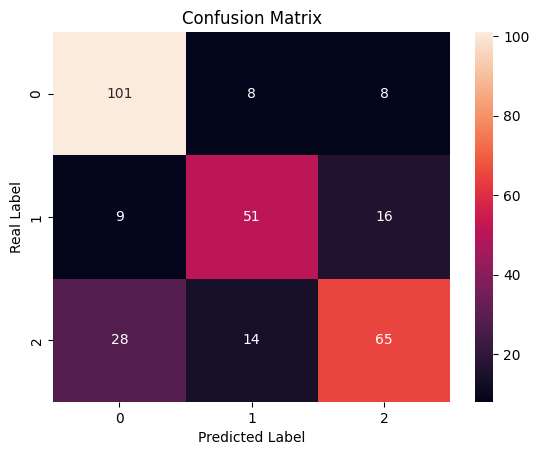

In [1230]:
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('Real Label')
plt.title('Confusion Matrix')
plt.show()

## Test Section 

This section is reserved for testing and evaluation purposes. The result of this section is annotate the validation test set

In [1231]:
x = test_set
y_pred = model.predict(x)

In [1232]:
# Annotate the results
test = pd.read_csv('test_unlabeled.csv', sep=',')
test.insert(len(test.columns), 'label', y_pred)
test.to_csv('Many_Naps_Little_Progress_modello1.csv', sep=',')